# Kaggle - Regression - Housing Price Market Predictions

## Jules MOTYL / Sébastien PAVOT

## Libraries:

In [472]:
# pip install boruta

Note: you may need to restart the kernel to use updated packages.


  ERROR: Could not find a version that satisfies the requirement skfeature (from versions: none)
ERROR: No matching distribution found for skfeature


In [517]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Data importation:

In [393]:
# Data = "C:/Users/jmotyl/Documents/GitHub/Kaggle-Competition-Regression-HousingPriceMarket-Python/Data/"

In [394]:
Data = "C:/Users/spavot/Documents/GitHub/Kaggle-Competition-Regression-HousingPriceMarket-Python/Data/"

In [395]:
train = pd.read_csv(Data + "train.csv")

In [396]:
test = pd.read_csv(Data + "test.csv")

We create a full dataset by stacking train & test data, this dataset will be used to process the data and after we will divide it again into train and test set:

In [397]:
full = all_data = pd.concat((train, test)).reset_index(drop=True)
full = full.drop(['SalePrice'], axis =1)
full.shape

(2919, 80)

## Part 1: Data exploration:

### Analyze the dependent variable : SalePrice

In [398]:
#descriptive statistics summary
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

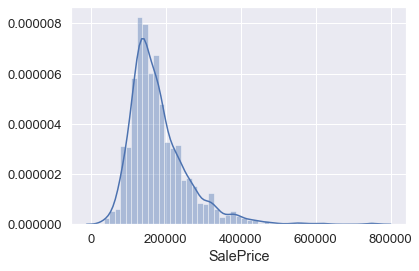

In [399]:
#Histogram vizualisation
sns.distplot(train['SalePrice']);

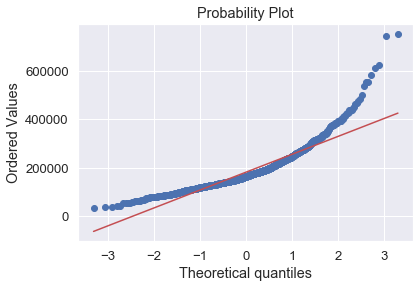

In [400]:
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

We can see that the SalePrice variable is right skewed meaning that we will found a small amount of house that have a price way higher than the median.

We can see that it's not normally distributed.

Now, we check the 11 variables that are the most correlated with SalePrice using the corr() function. Let's print it in a heatmap using seaborn in order to have a good vizualisation:

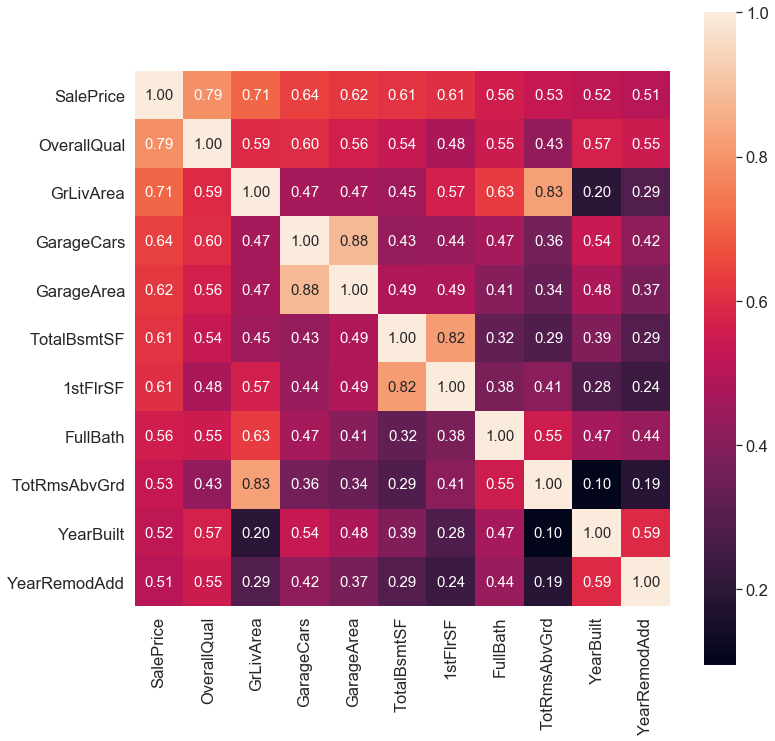

In [401]:
#saleprice correlation matrix
corrmat = train.corr()
k = 11 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.50)
fig, ax = plt.subplots(figsize=(12,12))  
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

As example, we can see that SalePrice and GarageCars are correlated but GarageCar is nearly strongly correlated with OverallQual. Here the size of the garage seems to be correlated with the overall quality of the material and the finish of the house. It's seems to be logical but we can maybe find stronger correlation between OverallQual and GarageQual as the garage quality will definitely have an impact on the overall quality.

The eleven most correlated variable with SalePrice are:
 * OverallQual
 * GrLivArea
 * GarageCars
 * GarageArea
 * TotalBsmtSF
 * 1stFlrSF
 * FullBath
 * TotRmsAbvGrd
 * YearBuilt
 * YearRemodAdd

Now that we've more comprehension of the dependent variable, let's have a first look at the predictors:

### Analyze the predictors:

Bellow, we plot a correlation heatmap using once again seaborn in order to have a quick overall ideal of correlation between all the variables:

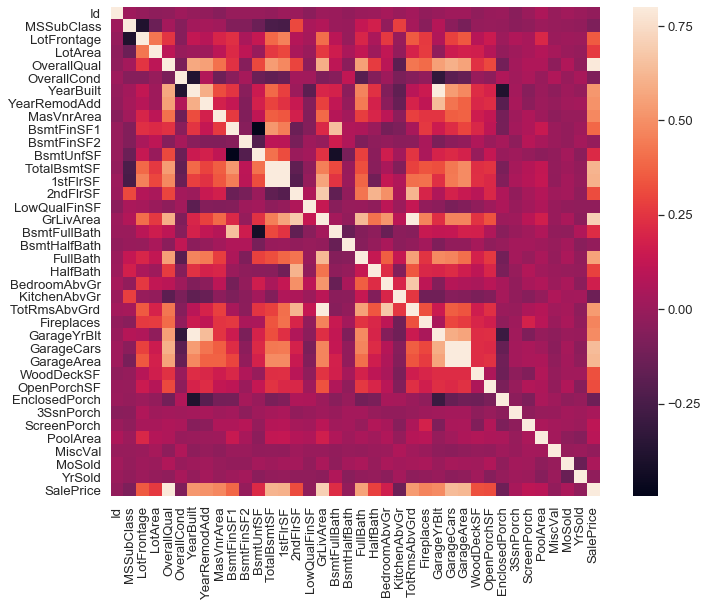

In [402]:
corrmat = train.corr()
sns.set(font_scale= 1.2)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, xticklabels=True, yticklabels=True);

We've now an overview of the correlation, as a macro view, we can say that some variables are correlated together wether negatively or positvely. This fact might lead to multicolinearity in our modeling part so we have to take this into account and to avoid that in order to have a better model. One can enjoy spend time of looking at correlation for each predictor but we won't dig into details here.

### Missing value analysis:

We will first create a dataframe containing the missing ratio (in percentage) of all predictors containing missing values:

In [403]:
# We create a full dataset by stacking train & test data:

full = pd.concat((train, test)).reset_index(drop=True)
full = full.drop(['SalePrice'], axis =1)
full.shape

(2919, 80)

In [404]:
#the dataset:
full_na = (full.isnull().sum() / len(full)) * 100
#We now remove the obervations where there's no missing values and sort it descennding
full_na = full_na.drop(full_na[full_na == 0].index).sort_values(ascending=False)

In [405]:
#We create a varibale containing the percentage of missing values by diving the sum of missing values by the length of 
#the dataset:
full_na = (full.isnull().sum() / len(all_data)) * 100
#We now remove the obervations where there's no missing values and sort it descennding
full_na = full_na.drop(full_na[full_na == 0].index).sort_values(ascending=False)
#We name this column and turn the full_na into a dataframe and then print it:
missing_data = pd.DataFrame({'Missing Ratio' :full_na})
missing_data

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageQual,5.447071
GarageCond,5.447071
GarageFinish,5.447071
GarageYrBlt,5.447071


We now plot this into an horizontal barchart for more visualization:

Text(0.5, 1.0, 'Percentages of missing values per features')

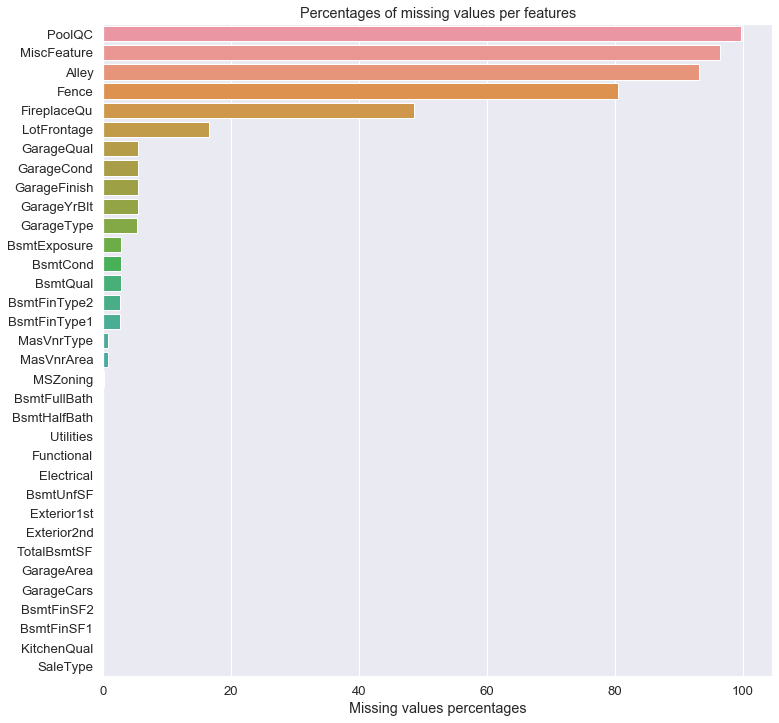

In [406]:
#Adapt the size of the plot
fig, ax = plt.subplots(figsize=(12,12))
#Plot the barplot
sns.barplot(x = full_na, y = full_na.index)
#Add labels
plt.xlabel("Missing values percentages")
plt.title("Percentages of missing values per features")

### Outliers analysis:

The dataset descriptions give us the following about outliers: _"Potential Pitfalls (Outliers): Although all known errors were corrected in the data, no
observations have been removed due to unusual values and all final residential sales
from the initial data set are included in the data presented with this article. There are
five observations that an instructor may wish to remove from the data set before giving
it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these
points). Three of them are true outliers (Partial Sales that likely don’t represent actual
market values) and two of them are simply unusual sales (very large houses priced
relatively appropriately). I would recommend removing any houses with more than
4000 square feet from the data set (which eliminates these five unusual observations)
before assigning it to students."_

Let's plot SalePrice versus GR LIV AREA:

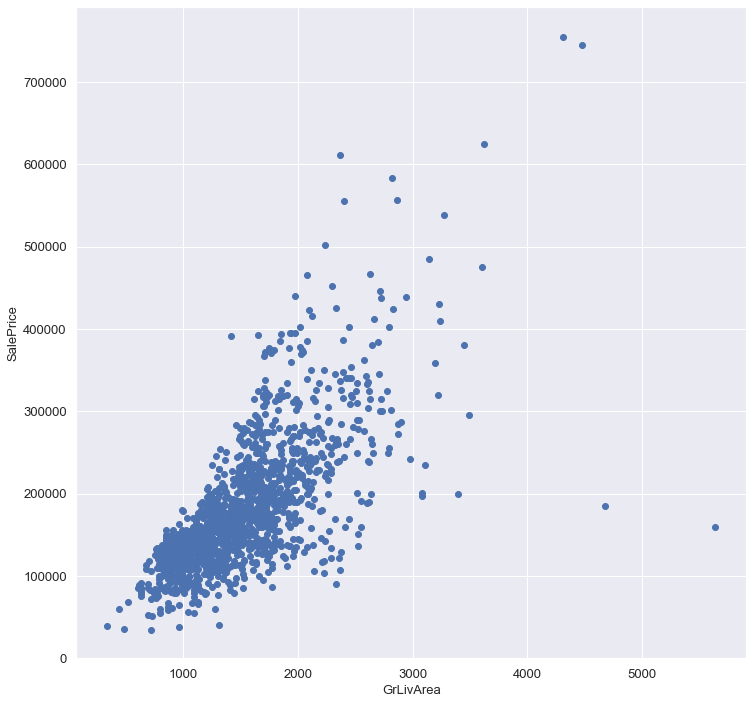

In [407]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

We can identify 4 outliers as those 4 are really far from the distribution of others values.

## Part 2: Data Processing:

### Outliers treatment:

As explained before, we have 4 outliers in GrLivArea that are really extreme values, we're going to drop from the dataset and the observations related in order to avoid any impact of those.

In [408]:
train.shape

(1460, 81)

In [409]:
train = train.loc[train["GrLivArea"]<4000,:]

In [410]:
train.shape

(1456, 81)

We correctly removed the 4 outliers, now if we plot SalePrice over GrLivArea, we find that:

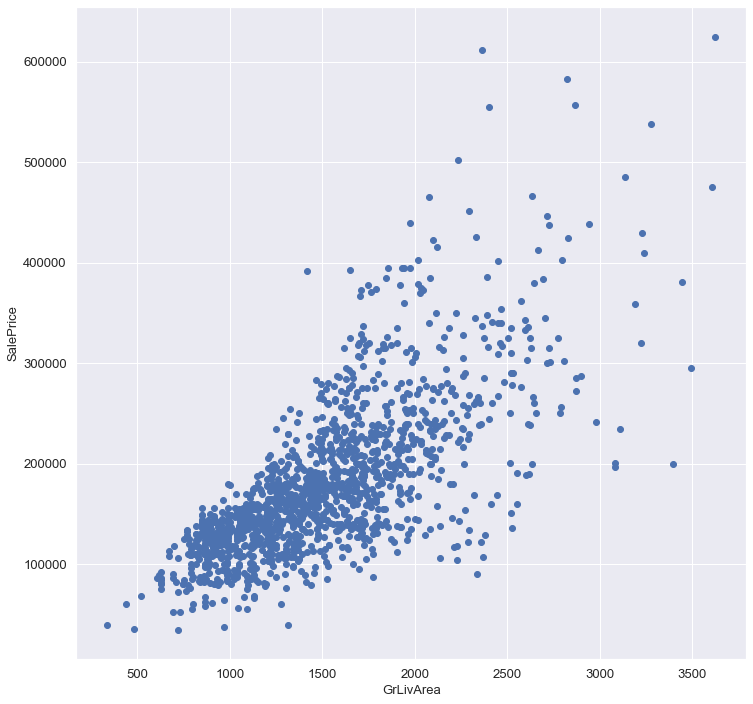

In [411]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

The plot don't show any outliers anymore.

### Missing values imputation:

In [412]:
train.shape

(1456, 81)

In [413]:
# here i'm building a table that will display the count of values per variable
#I will use it to identify which variable have missing values and needs attention.
# This does not detect variables that have a majority of 0s however.
counting= pd.DataFrame(columns=["var","cnt"])
var=[]
cnt=[]
for i in list(train.columns):
    var.append(i)
    cnt.append(train[i].count())
counting["var"]=var
counting["cnt"]=cnt

display(counting[counting.cnt<1460]) #those values have at least one missing value
print(counting[counting.cnt<1460].count())

,var,cnt
0,Id,1456
1,MSSubClass,1456
2,MSZoning,1456
3,LotFrontage,1197
4,LotArea,1456
5,Street,1456
6,Alley,91
7,LotShape,1456
8,LandContour,1456
9,Utilities,1456


var    81
cnt    81
dtype: int64


In [414]:
ToReg = np.array(list(counting["var"][counting.cnt<1460]))
ToReg #This is the list of variables that have at least 1 missing

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'Pav

In [415]:
train.PoolQC[train["PoolQC"].isnull()]  = "No"
train.Fence[train["Fence"].isnull()]  = "No"
train.Alley[train["Alley"].isnull()]  = "No"
train.MiscFeature[train["MiscFeature"].isnull()]  = "No"
train.FireplaceQu[train.Fireplaces==0] = "No"
train.MasVnrType[train['MasVnrType'].isnull()] = "No"
train.MasVnrArea[train['MasVnrArea'].isnull()] = 0
train.GarageYrBlt[train['GarageYrBlt'].isnull()] = 0

train["IsBasement"] = "NA"
train["IsBasement"][train.BsmtQual.isnull()] = 0
train["IsBasement"][~train.BsmtQual.isnull()] = 1
train["IsGarage"] = "NA"
train["IsGarage"][train.GarageType.isnull()] = 0
train["IsGarage"][~train.GarageType.isnull()] = 1

GarageVar = ['GarageType','GarageFinish', 'GarageQual', 'GarageCond']
BasementVar = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2']

for i in GarageVar:
    train[i][train.IsGarage==0] = "No"
for i in BasementVar:
    train[i][train.IsBasement==0] = "No"

In [416]:
display(train[BasementVar][train.BsmtFinType2.isnull()])

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
332,Gd,TA,No,GLQ,NaN


In [417]:
train.BsmtExposure[train.BsmtExposure.isnull()] = "No"
train.BsmtFinType2[train.BsmtFinType2.isnull()] = "Unf"
train.Electrical[train.Electrical.isnull()] = "Mix"

In [418]:
display(train[ToReg])

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,No,IR1,Lvl,AllPub,...,0,No,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,No,IR1,Lvl,AllPub,...,0,No,No,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,1,2008,WD,Normal,118000


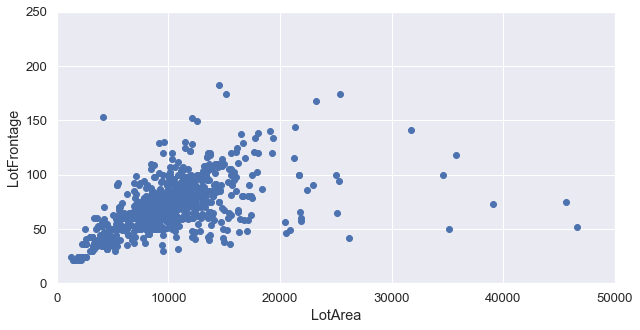

In [419]:
plt.scatter(train.LotArea[~train.LotFrontage.isnull()],train.LotFrontage[~train.LotFrontage.isnull()]) #I want to look at the relation between each variable with missing values
plt.xlabel('LotArea')                     # and the Orientation Economique of the bassin it belongs to
plt.ylabel('LotFrontage')
fig = matplotlib.pyplot.gcf()
axes = plt.gca()
axes.set_xlim([0,50000])
axes.set_ylim([0,250])
fig.set_size_inches(10,5)
plt.show()

In [420]:
SimpleLinearC = LinearRegression().fit(train.LotArea[~train.LotFrontage.isnull()].values.reshape(-1,1),train.LotFrontage[~train.LotFrontage.isnull()].values.reshape(-1,1))

In [421]:
#Getting the coefficients and intercept for every variable
CIntercept = SimpleLinearC.intercept_
CCoefficient = SimpleLinearC.coef_

In [422]:
#replacing the null values in variables by multiplying the population by the corresponding coefficient
train.LotFrontage[train.LotFrontage.isnull()] = np.round(CCoefficient * train.LotArea.values[train.LotFrontage.isnull()],0) + CIntercept

#### test set : replacement of missing values

In [423]:
test.shape

(1459, 80)

In [424]:
# here i'm building a table that will display the count of values per variable
#I will use it to identify which variable have missing values and needs attention.
# This does not detect variables that have a majority of 0s however.
counting= pd.DataFrame(columns=["var","cnt"])
var=[]
cnt=[]
for i in list(test.columns):
    var.append(i)
    cnt.append(test[i].count())
counting["var"]=var
counting["cnt"]=cnt

display(counting[counting.cnt<1459]) #those values have at least one missing value
print(counting[counting.cnt<1459].count())

,var,cnt
2,MSZoning,1455
3,LotFrontage,1232
6,Alley,107
9,Utilities,1457
23,Exterior1st,1458
24,Exterior2nd,1458
25,MasVnrType,1443
26,MasVnrArea,1444
30,BsmtQual,1415
31,BsmtCond,1414


var    33
cnt    33
dtype: int64


In [425]:
ToReg = np.array(list(counting["var"][counting.cnt<1459]))
ToReg #This is the list of variables that have at least 1 missing

array(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType'], dtype='<U12')

In [426]:
#Replacing NAs
test.PoolQC[test["PoolQC"].isnull()]  = "No"
test.Fence[test["Fence"].isnull()]  = "No"
test.Alley[test["Alley"].isnull()]  = "No"
test.MiscFeature[test["MiscFeature"].isnull()]  = "No"
test.FireplaceQu[test.Fireplaces==0] = "No"
test.MasVnrType[test['MasVnrType'].isnull()] = "No"
test.MasVnrArea[test['MasVnrType']==0] = 0

test["IsBasement"] = "NA"
test["IsBasement"][test.BsmtQual.isnull()] = 0
test["IsBasement"][~test.BsmtQual.isnull()] = 1
test["IsGarage"] = "NA"
test["IsGarage"][test.GarageType.isnull()] = 0
test["IsGarage"][~test.GarageType.isnull()] = 1

GarageVar = ['GarageType','GarageFinish', 'GarageQual', 'GarageCond']
BasementVar = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2']

for i in GarageVar:
    test[i][test.IsGarage==0] = "No"
for i in BasementVar:
    test[i][test.IsBasement==0] = "No"

In [427]:
# here i'm building a table that will display the count of values per variable
#I will use it to identify which variable have missing values and needs attention.
# This does not detect variables that have a majority of 0s however.
counting= pd.DataFrame(columns=["var","cnt"])
var=[]
cnt=[]
for i in list(test.columns):
    var.append(i)
    cnt.append(test[i].count())
counting["var"]=var
counting["cnt"]=cnt

display(counting[counting.cnt<1459]) #those values have at least one missing value
print(counting[counting.cnt<1459].count())

,var,cnt
2,MSZoning,1455
3,LotFrontage,1232
9,Utilities,1457
23,Exterior1st,1458
24,Exterior2nd,1458
26,MasVnrArea,1444
31,BsmtCond,1456
32,BsmtExposure,1457
34,BsmtFinSF1,1458
36,BsmtFinSF2,1458


var    23
cnt    23
dtype: int64


In [428]:
ToReg = np.array(list(counting["var"][counting.cnt<1459]))
ToReg #This is the list of variables that have at least 1 missing

array(['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrArea', 'BsmtCond', 'BsmtExposure',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'SaleType'], dtype='<U12')

In [429]:
#replacing the null values in variables by multiplying the population by the corresponding coefficient
test.LotFrontage[test.LotFrontage.isnull()] = np.round(CCoefficient * test.LotArea.values[test.LotFrontage.isnull()],0) + CIntercept

In [430]:
test[GarageVar][test.GarageFinish.isnull()]

,GarageType,GarageFinish,GarageQual,GarageCond
666,Detchd,NaN,NaN,NaN
1116,Detchd,NaN,NaN,NaN


In [431]:
pd.unique(test.GarageFinish)

array(['Unf', 'Fin', 'RFn', 'No', nan], dtype=object)

In [432]:
test.GarageFinish[test.GarageFinish.isnull()] = "Fin"
test.GarageQual[test.GarageQual.isnull()] = "TA"
test.GarageCond[test.GarageCond.isnull()] = "TA"

In [433]:
test.MasVnrType[test.MasVnrArea.isnull()]

231     No
246     No
422     No
532     No
544     No
581     No
851     No
865     No
880     No
889     No
908     No
1132    No
1197    No
1226    No
1402    No
Name: MasVnrType, dtype: object

In [434]:
test.MasVnrArea[test.MasVnrArea.isnull()] = 0

In [435]:
np.sort(pd.unique(test.GarageYrBlt))

array([1895., 1896., 1900., 1910., 1915., 1916., 1917., 1918., 1919.,
       1920., 1921., 1922., 1923., 1924., 1925., 1926., 1927., 1928.,
       1930., 1932., 1934., 1935., 1936., 1937., 1938., 1939., 1940.,
       1941., 1942., 1943., 1945., 1946., 1947., 1948., 1949., 1950.,
       1951., 1952., 1953., 1954., 1955., 1956., 1957., 1958., 1959.,
       1960., 1961., 1962., 1963., 1964., 1965., 1966., 1967., 1968.,
       1969., 1970., 1971., 1972., 1973., 1974., 1975., 1976., 1977.,
       1978., 1979., 1980., 1981., 1982., 1983., 1984., 1985., 1986.,
       1987., 1988., 1989., 1990., 1991., 1992., 1993., 1994., 1995.,
       1996., 1997., 1998., 1999., 2000., 2001., 2002., 2003., 2004.,
       2005., 2006., 2007., 2008., 2009., 2010., 2207.,   nan])

In [436]:
test.GarageYrBlt[test.GarageYrBlt==2207] = 2007 #Regularizing obvious outlier
test.GarageYrBlt[test.GarageYrBlt.isnull()] = test.GarageYrBlt.mean()

In [437]:
test.BsmtCond[test.BsmtCond.isnull()] = "TA"
test.BsmtExposure[test.BsmtExposure.isnull()] = "Av"
test.BsmtFinSF1[test.BsmtFinSF1.isnull()] = 0
test.BsmtFinSF2[test.BsmtFinSF2.isnull()] = 0
test.BsmtHalfBath[test.BsmtHalfBath.isnull()] = 0
test.BsmtUnfSF[test.BsmtUnfSF.isnull()] = 0
test.BsmtFullBath[test.BsmtFullBath.isnull()] = 0

In [438]:
test.GarageCars[test.GarageCars.isnull()] = test.GarageCars.mean()
test.GarageArea[test.GarageArea.isnull()] = test.GarageArea.mean()

In [439]:
test.MSZoning[test.MSZoning.isnull()] ='C (all)'
test.Utilities[test.Utilities.isnull()] ='AllPub'
test.Exterior1st[test.Exterior1st.isnull()] ='Other'
test.Exterior2nd[test.Exterior2nd.isnull()] ='Other'
test.TotalBsmtSF[test.TotalBsmtSF.isnull()] = test.TotalBsmtSF.mean()
test.KitchenQual[test.KitchenQual.isnull()] ='TA'
test.Functional[test.Functional.isnull()] ='Typ'
test.SaleType[test.SaleType.isnull()] ='Oth'

In [440]:
# here i'm building a table that will display the count of values per variable
#I will use it to identify which variable have missing values and needs attention.
# This does not detect variables that have a majority of 0s however.
counting= pd.DataFrame(columns=["var","cnt"])
var=[]
cnt=[]
for i in list(test.columns):
    var.append(i)
    cnt.append(test[i].count())
counting["var"]=var
counting["cnt"]=cnt

display(counting[counting.cnt<len(test)]) #those values have at least one missing value
print(counting[counting.cnt<len(test)].count())

,var,cnt


var    0
cnt    0
dtype: int64


No variable has null value anymore.

## Part 3: Features engineering:

### Transforming categorical ordinal variables into numerical ordinal variables:

Some variables are ordinate with special text values like good or bad, we replace them that are encoded this way with number with 5 for the higher score, 1 for lowest and 0 where this value is missing.

In [441]:
CatColsOrd = ('ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
             'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC')

In [442]:
def EncodingCatVar(x,c):
    for cols in c:
        x[cols] = x[cols].str.upper()
        x.loc[x[cols] == "EX", cols] = 5
        x.loc[x[cols] == "GD", cols] = 4
        x.loc[x[cols] == "TA", cols] = 3
        x.loc[x[cols] == "FA", cols] = 2
        x.loc[x[cols] == "PO", cols] = 1
        x.loc[x[cols] == "NO", cols] = 0



In [443]:
EncodingCatVar(train, CatColsOrd)
EncodingCatVar(test, CatColsOrd)


For the others that might be encoded specificly, we will use the dummy approach instead.

### Transforming numerical variable that are in fact categorical:

We identified the three following variables as coded as numerical but they don't have any order of the values. It's means that in fact they are really categorical variable that were encoded with number. In our model, it can lead to giving more importance to an higher value (for example december = 12) that will make december more important than January (=1) where there are equal. To fix this, we will transform them into string:
* MSSubClass: 
* MoSold: 
* YrSold:

In [444]:
train['MoSold'] = train['MoSold'].astype(str)
train['YrSold'] = train['YrSold'].astype(str)
train['MSSubClass'] = train['MSSubClass'].astype(str)

test['MoSold'] = test['MoSold'].astype(str)
test['YrSold'] = test['YrSold'].astype(str)
test['MSSubClass'] = test['MSSubClass'].astype(str)

So now, we will be able to dummy encode them later.

### Creation of new columns:

We can create the total house square floor area by summing the total basement area + the total 1st floor + the total second floor:

In [445]:
train['TotalSquareFloor'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

test['TotalSquareFloor'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

We can also compute the average score of all the categorical ordinal variables that we transformed before:

In [446]:
train['AvgScoreCatOrd'] = train[['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
             'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']].mean(axis = 1)

test['AvgScoreCatOrd'] = test[['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
             'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']].mean(axis = 1)

### Dummy encoding the categorical variables:

We first check if everything is equal in the training and test set about columns types and information:

In [447]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1459
Data columns (total 85 columns):
Id                  1456 non-null int64
MSSubClass          1456 non-null object
MSZoning            1456 non-null object
LotFrontage         1456 non-null float64
LotArea             1456 non-null int64
Street              1456 non-null object
Alley               1456 non-null object
LotShape            1456 non-null object
LandContour         1456 non-null object
Utilities           1456 non-null object
LotConfig           1456 non-null object
LandSlope           1456 non-null object
Neighborhood        1456 non-null object
Condition1          1456 non-null object
Condition2          1456 non-null object
BldgType            1456 non-null object
HouseStyle          1456 non-null object
OverallQual         1456 non-null int64
OverallCond         1456 non-null int64
YearBuilt           1456 non-null int64
YearRemodAdd        1456 non-null int64
RoofStyle           1456 non-null obj

In [448]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 84 columns):
Id                  1459 non-null int64
MSSubClass          1459 non-null object
MSZoning            1459 non-null object
LotFrontage         1459 non-null float64
LotArea             1459 non-null int64
Street              1459 non-null object
Alley               1459 non-null object
LotShape            1459 non-null object
LandContour         1459 non-null object
Utilities           1459 non-null object
LotConfig           1459 non-null object
LandSlope           1459 non-null object
Neighborhood        1459 non-null object
Condition1          1459 non-null object
Condition2          1459 non-null object
BldgType            1459 non-null object
HouseStyle          1459 non-null object
OverallQual         1459 non-null int64
OverallCond         1459 non-null int64
YearBuilt           1459 non-null int64
YearRemodAdd        1459 non-null int64
RoofStyle           1459 non-null obj

In [449]:
for i in train.columns:
    if i not in test.columns:
        print(i)

SalePrice


The only column that is not in the test set is our target variable, we can now dummy encode the categorical columns:

In [450]:
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

In [451]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1459
Columns: 260 entries, Id to IsGarage_1
dtypes: float64(4), int64(43), uint8(213)
memory usage: 848.9 KB


In [452]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 247 entries, Id to IsGarage_1
dtypes: float64(13), int64(33), uint8(201)
memory usage: 810.8 KB


We can see that we have more columns in the training than in the test set. It's due by the fact that some categories that were turn into column after dummy encoding existed in the training but not in the test set. It's also possible that the opposite occures and some columns in the test set are not present in the training test. To fix it, we're going to create all the missing columns of training and test sets and assign them to a value of 0 so they don't have any impact.

In [453]:
for i in train.columns:
    if i not in test.columns and i != "SalePrice":
        test[i] = 0
        print(i,"has been added to the test set as it was missing")

Utilities_NoSeWa has been added to the test set as it was missing
Condition2_RRAe has been added to the test set as it was missing
Condition2_RRAn has been added to the test set as it was missing
Condition2_RRNn has been added to the test set as it was missing
HouseStyle_2.5Fin has been added to the test set as it was missing
RoofMatl_Membran has been added to the test set as it was missing
RoofMatl_Metal has been added to the test set as it was missing
RoofMatl_Roll has been added to the test set as it was missing
Exterior1st_ImStucc has been added to the test set as it was missing
Exterior1st_Stone has been added to the test set as it was missing
Heating_GasA has been added to the test set as it was missing
Heating_OthW has been added to the test set as it was missing
Electrical_Mix has been added to the test set as it was missing
MiscFeature_TenC has been added to the test set as it was missing


In [454]:
for i in test.columns:
    if i not in train.columns and i != "SalePrice":
        train[i] = 0
        print(i,"has been added to the test set as it was missing")

MSSubClass_150 has been added to the test set as it was missing
Exterior1st_Other has been added to the test set as it was missing


In [455]:
print(test.shape)
print(train.shape)
a = 0
for i in train.columns:
    if i in test.columns:
        a = a + 1
print(a)

(1459, 261)
(1456, 262)
261


Now, we have exactly the same independent variables in the training and the test set, the only difference is the SalePrice which is our independent variable which is only in the training set.

We can now perform our features selection:

# TO DISCUSS: ADD FLAG COLUMN FOR MISSING VALUES IN NUMERICAL COLUMNS REPLACED WITH 0.

## Part 4: Features Selection:

We initiate the trainX and trainY array for the modeling:

In [456]:
features = [i for i in train.columns if i not in ['SalePrice','Id']]
len(features)

260

In [457]:
trainX = train[features].values
trainY = train['SalePrice'].values.ravel()

### A) Boruta Method:

We initiate the trainX and trainY array for the modeling:

In [456]:
features = [i for i in train.columns if i not in ['SalePrice','Id']]
len(features)

260

In [457]:
trainX = train[features].values
trainY = train['SalePrice'].values.ravel()

Next step is to initiate a Random Forest classifier:

In [458]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

We then run the boruta model with a random seed to make it reproducible. We set the max iter to 50 and percentage to 70
to only select observations that are above this threshold of 85%.

In [463]:
random.seed(1)
boruta_feature_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=123, max_iter = 50, perc= 70)
boruta_feature_selector.fit(trainX, trainY)

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	260
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	260
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	260
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	260
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	260
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	260
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	260
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	39
Tentative: 	83
Rejected: 	138
Iteration: 	9 / 50
Confirmed: 	39
Tentative: 	83
Rejected: 	138
Iteration: 	10 / 50
Confirmed: 	39
Tentative: 	83
Rejected: 	138
Iteration: 	11 / 50
Confirmed: 	39
Tentative: 	83
Rejected: 	138
Iteration: 	12 / 50
Confirmed: 	39
Tentative: 	48
Rejected: 	173
Iteration: 	13 / 50
Confirmed: 	39
Tentative: 	48
Rejected: 	173
Iteration: 	14 / 50
Confirmed: 	39
Tentative: 	48
Rejected: 	173
Iteration: 	15 / 50
Confirmed: 	39
Tentative: 	48
Rejected: 	173
Iteration: 	16 / 50
Confirmed: 	39
Tentative: 	3

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True,
                                          class_weight='balanced',
                                          criterion='gini', max_depth=5,
                                          max_features='auto',
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=181, n_jobs=-1,
                                          oob_score=False,
                                          random_state=<mtrand.RandomState object at 0x000001FA4929CB40>,
                                          verbose=0, warm_start=False),
         max_i

We can now assign the variables selected to our training set:

In [464]:
trainXBoruta = boruta_feature_selector.transform(trainX)
trainXBoruta.shape

(1456, 39)

We get a list of the selected features:

In [466]:
final_features = list()
indexes = np.where(boruta_feature_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(features[x])
print(final_features)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MiscVal', 'TotalSquareFloor', 'AvgScoreCatOrd', 'SaleType_Con', 'SaleType_New', 'SaleCondition_Alloca']


We now create the dataframe with the selected features:

In [552]:
trainXBoruta = train.loc[:, final_features]
testBoruta = test.loc[:, final_features]

In [555]:
print(trainXBoruta.shape)
print(testBoruta.shape)

(1456, 39)
(1459, 39)


### B) Principal Component analysis:

### NOTE: Not finished yet

First step is to standardize the data:

In [541]:
stdFeatTrain = train.loc[:, features].values
stdFeatTrain = StandardScaler().fit_transform(stdFeatTrain)

stdFeatTest = test.loc[:, test.columns !='Id'].values
stdFeatTest = StandardScaler().fit_transform(stdFeatTest)

We now create a dataframe:

In [514]:
stdFeatTrain = pd.DataFrame(stdFeatTrain, columns = train.loc[:, features].columns)
stdFeatTrain.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,IsBasement_1,IsGarage_1,MSSubClass_150,Exterior1st_Other
0,-0.240614,-0.202770,0.665646,-0.517461,1.053769,0.880629,0.533895,1.066349,-0.238458,0.589513,...,0.388572,-0.052486,-0.091161,-0.118015,0.465160,-0.303765,0.161477,0.242712,0.0,0.0
1,0.444216,-0.086107,-0.064709,2.176545,0.159469,-0.427190,-0.573757,-0.688006,-0.238458,0.589513,...,0.388572,-0.052486,-0.091161,-0.118015,0.465160,-0.303765,0.161477,0.242712,0.0,0.0
2,-0.103648,0.081281,0.665646,-0.517461,0.987524,0.832191,0.341751,1.066349,-0.238458,0.589513,...,0.388572,-0.052486,-0.091161,-0.118015,0.465160,-0.303765,0.161477,0.242712,0.0,0.0
3,-0.468891,-0.091179,0.665646,-0.517461,-1.860986,-0.717817,-0.573757,-0.688006,-0.238458,-0.554928,...,0.388572,-0.052486,-0.091161,-0.118015,-2.149796,-0.303765,0.161477,0.242712,0.0,0.0
4,0.626837,0.386636,1.396000,-0.517461,0.954402,0.735316,1.404192,1.066349,-0.238458,0.589513,...,0.388572,-0.052486,-0.091161,-0.118015,0.465160,-0.303765,0.161477,0.242712,0.0,0.0


In [542]:
stdFeatTest = pd.DataFrame(stdFeatTest, columns = test.loc[:, test.columns != "Id"].columns)
stdFeatTest.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,HouseStyle_2.5Fin,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,Exterior1st_ImStucc,Exterior1st_Stone,Heating_GasA,Heating_OthW,Electrical_Mix,MiscFeature_TenC
0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,81.0,14267.0,6.0,6.0,1958.0,1958.0,108.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,74.0,13830.0,5.0,5.0,1997.0,1998.0,0.0,3.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,78.0,9978.0,6.0,6.0,1998.0,1998.0,20.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,43.0,5005.0,8.0,5.0,1992.0,1992.0,0.0,4.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We want to obtain 50 components:

In [543]:
PCAComp = PCA(n_components=50)

PCAtrain = PCAComp.fit_transform(stdFeatTrain)

PCAtest = PCAComp.fit_transform(stdFeatTest)

We transform the results into a dataframe:

In [545]:
PCAtrain = pd.DataFrame(data = PCAtrain)
PCAtrain.head()


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-3.706439,1.868243,0.072164,-0.336870,1.546813,3.043070,-1.206661,0.965657,-0.327198,-2.126229,...,0.627709,0.245060,0.027959,-0.329782,1.250457,0.649673,0.434139,0.452556,0.640752,-0.644166
1,-0.294149,-3.023820,0.220554,-0.913011,-1.150826,-0.121128,0.189587,0.627296,1.445265,-0.360417,...,1.994546,-2.190442,0.025605,0.688110,-1.314294,-1.145364,1.201942,-2.561212,1.224210,1.529890
2,-4.536270,1.643229,0.150013,0.053277,0.633868,2.490609,-0.889536,1.752254,-0.239787,-1.890054,...,-0.088283,0.023283,-0.885516,-0.750125,-0.432191,2.023852,0.057441,-0.388179,-0.700340,0.688867
3,0.769292,1.028086,-3.836211,0.894937,-1.075394,-1.322935,0.164774,0.946096,-0.885786,-0.475533,...,-0.113302,-0.476547,0.118584,0.116441,0.649869,1.233960,1.270528,1.778804,1.078580,-0.321815
4,-6.304484,1.588174,-0.382645,2.200116,-0.225136,2.982895,-0.499257,0.860086,-0.688700,-2.780551,...,1.922393,-0.189642,1.094405,0.734518,0.394816,0.605123,-0.428904,0.225553,-0.195651,0.293829


In [544]:
PCAtest = pd.DataFrame(data = PCAtest)
PCAtest.head()


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1712.393633,-1115.156791,250.541882,-367.977402,-19.905157,-87.146279,-150.434600,342.231825,-118.028941,9.483277,...,0.365365,-0.087954,0.683497,0.504272,-0.132086,-0.267725,1.385366,0.133355,-0.277436,0.616102
1,4678.492020,1556.669893,11152.967800,4970.749767,1300.229184,-131.210939,-139.499053,186.767104,-84.275358,141.351023,...,-0.591611,0.050903,-0.731115,1.003708,0.191397,0.511298,0.917813,-0.022553,0.586087,-0.239772
2,3991.106625,-362.858619,-53.482669,102.053601,-694.126770,-257.971606,-31.365537,-38.522853,-94.506406,95.214883,...,0.566460,0.618346,0.578650,-0.245759,0.133534,-0.729879,0.304140,-0.228794,0.335275,0.229149
3,151.283484,-52.932277,-93.206304,186.783716,-472.172549,-175.998529,-35.729030,2.089361,-81.756036,253.291545,...,-0.479492,0.144544,-0.381897,0.395045,0.371359,-0.220684,0.962282,-0.470814,0.968201,-0.128487
4,-4789.930514,490.783592,-15.507871,-222.860856,642.802258,5.852346,47.397798,28.344132,-102.773774,-74.412838,...,-0.182780,0.251630,-0.402338,-0.573910,-0.515837,-0.642985,0.207930,-0.687583,-0.257156,0.629940


We print the variance explained per component and the total:

Training test:

In [546]:
print('Explained variation per principal component: {}'.format(PCAComp.explained_variance_ratio_))
print('Sum of explained variation:', (PCAComp.explained_variance_ratio_).sum())

Explained variation per principal component: [9.20979124e-01 3.57833069e-02 1.47219155e-02 1.19576257e-02
 9.86150802e-03 2.13686416e-03 1.44592897e-03 1.13411648e-03
 8.11375451e-04 5.22350578e-04 1.71468336e-04 1.46630893e-04
 1.14371158e-04 1.03570372e-04 3.29324949e-05 3.11596835e-05
 1.51098928e-05 1.03428929e-05 7.62021071e-06 7.28294925e-06
 4.74668016e-06 9.66455071e-08 4.18231559e-08 3.73347157e-08
 2.97673322e-08 2.33452713e-08 2.19379318e-08 1.68372691e-08
 1.48786880e-08 1.30176460e-08 1.20150277e-08 1.13700337e-08
 1.07775117e-08 9.96377292e-09 9.03817156e-09 8.98340060e-09
 8.73908334e-09 8.36874659e-09 8.07269957e-09 7.71533723e-09
 7.59686084e-09 7.37482444e-09 7.13582804e-09 6.98124341e-09
 6.76927212e-09 6.54187363e-09 6.13839872e-09 5.90888751e-09
 5.86856687e-09 5.67331373e-09]
Sum of explained variation: 0.9999998082122554


Test set:

In [547]:
print('Explained variation per principal component: {}'.format(PCAComp.explained_variance_ratio_))
print('Sum of explained variation:', (PCAComp.explained_variance_ratio_).sum())

Explained variation per principal component: [9.20979124e-01 3.57833069e-02 1.47219155e-02 1.19576257e-02
 9.86150802e-03 2.13686416e-03 1.44592897e-03 1.13411648e-03
 8.11375451e-04 5.22350578e-04 1.71468336e-04 1.46630893e-04
 1.14371158e-04 1.03570372e-04 3.29324949e-05 3.11596835e-05
 1.51098928e-05 1.03428929e-05 7.62021071e-06 7.28294925e-06
 4.74668016e-06 9.66455071e-08 4.18231559e-08 3.73347157e-08
 2.97673322e-08 2.33452713e-08 2.19379318e-08 1.68372691e-08
 1.48786880e-08 1.30176460e-08 1.20150277e-08 1.13700337e-08
 1.07775117e-08 9.96377292e-09 9.03817156e-09 8.98340060e-09
 8.73908334e-09 8.36874659e-09 8.07269957e-09 7.71533723e-09
 7.59686084e-09 7.37482444e-09 7.13582804e-09 6.98124341e-09
 6.76927212e-09 6.54187363e-09 6.13839872e-09 5.90888751e-09
 5.86856687e-09 5.67331373e-09]
Sum of explained variation: 0.9999998082122554


And check that the dimensions are as expected:

In [537]:
PCAtrain.shape

(1456, 50)

### C) Pearson Correlation:

Create a Pearson Correlation function to return the correlation score ordered from the highest to the lowest:

In [482]:
def cor_selector2(df, target, num_feats):
    cor_list = []
    feature_name = df.columns.tolist()
    # calculate the correlation with the target for each feature of the dataframe
    for i in df.columns.tolist():
        cor = np.corrcoef(df[i], target)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # extract the name of the selected feature
    cor_feature = df.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [483]:
cor_support, cor_feature = cor_selector2(train, train['SalePrice'], 50)
print(str(len(cor_feature)), 'selected features')

50 selected features


In [485]:
print(cor_feature)

['CentralAir_Y', 'LotShape_Reg', 'GarageYrBlt', 'LotArea', 'GarageCond', 'GarageQual', 'HalfBath', 'Neighborhood_NoRidge', 'MSZoning_RM', '2ndFlrSF', 'BsmtExposure_Gd', 'BsmtExposure_No', 'WoodDeckSF', 'Exterior1st_VinylSd', 'Exterior2nd_VinylSd', 'OpenPorchSF', 'LotFrontage', 'GarageType_Attchd', 'Foundation_CBlock', 'MasVnrType_Stone', 'GarageType_Detchd', 'SaleCondition_Partial', 'MSSubClass_60', 'SaleType_New', 'MasVnrType_None', 'BsmtFinSF1', 'GarageFinish_Unf', 'Neighborhood_NridgHt', 'HeatingQC', 'BsmtFinType1_GLQ', 'Fireplaces', 'MasVnrArea', 'Foundation_PConc', 'YearRemodAdd', 'FireplaceQu', 'YearBuilt', 'TotRmsAbvGrd', 'FullBath', 'BsmtQual', '1stFlrSF', 'GarageArea', 'TotalBsmtSF', 'GarageCars', 'KitchenQual', 'ExterQual', 'GrLivArea', 'AvgScoreCatOrd', 'OverallQual', 'TotalSquareFloor', 'SalePrice']


We now create the dataframe with the selected features from Pearson Correlation:

In [558]:
trainXPearson = train.loc[:, cor_feature]
testPearson = test.loc[:, cor_feature]

In [559]:
print(trainXPearson.shape)
print(testPearson.shape)

(1456, 50)
(1459, 50)


## Part 5: Modelling:

Note: Some of the following model will not use the feature selection done aboe as their contain already a feature selection inside the model, we call them wrapper model.